# **Anomaly Detection in Oil Pumps Using Isolation Forest**

In this notebook, we will create an anomaly detection model for an oil pump system. We will generate synthetic data for normal and faulty behavior of the pump, preprocess the data, build an Isolation Forest model, and evaluate its performance.

---


## **1. Import Required Libraries**

In the first step, we will import the necessary libraries for data generation, preprocessing, model building, and evaluation.


In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
np.random.seed(42)

## **2. Generate Synthetic Data for Oil Pump**

We will simulate synthetic data for four key parameters of an oil pump:
- **Vibration**: High values indicate potential mechanical issues.
- **Temperature**: High values could signal overheating.
- **Pressure**: Low pressure could signal leaks or blockages.
- **Flow Rate**: Low flow could indicate operational problems.

### Normal and Anomalous Data Generation:
We create normal data with Gaussian noise and introduce anomalies (e.g., spikes in vibration and temperature, drops in pressure and flow rate).


In [4]:
# Parameters for data generation
n_data_points = 1000  # Total number of time steps
anomaly_fraction = 0.05  # Fraction of data that will contain anomalies
n_anomalies = int(n_data_points * anomaly_fraction)  # Number of anomaly points

# Time series index
time = np.arange(n_data_points)

# Normal operating range for each parameter (simulated)
vibration_normal = np.random.normal(loc=0.5, scale=0.05, size=n_data_points)  # Hz
temperature_normal = np.random.normal(loc=60, scale=2, size=n_data_points)  # °C
pressure_normal = np.random.normal(loc=120, scale=5, size=n_data_points)  # psi
flow_rate_normal = np.random.normal(loc=80, scale=3, size=n_data_points)  # L/s

# Introducing anomalies (spikes and drops)
vibration_anomaly = vibration_normal.copy()
temperature_anomaly = temperature_normal.copy()
pressure_anomaly = pressure_normal.copy()
flow_rate_anomaly = flow_rate_normal.copy()

# Randomly select points to introduce anomalies
anomaly_indices = np.random.choice(n_data_points, n_anomalies, replace=False)

# Introduce anomalies (e.g., higher vibration, temperature spikes, pressure drops, etc.)
vibration_anomaly[anomaly_indices] += np.random.uniform(0.5, 1.0, size=n_anomalies)  # spike in vibration
temperature_anomaly[anomaly_indices] += np.random.uniform(10, 15, size=n_anomalies)  # temperature spike
pressure_anomaly[anomaly_indices] -= np.random.uniform(10, 20, size=n_anomalies)  # pressure drop
flow_rate_anomaly[anomaly_indices] -= np.random.uniform(10, 15, size=n_anomalies)  # flow rate drop

# Create a DataFrame to hold the synthetic data
data = pd.DataFrame({
    'time': time,
    'vibration': vibration_anomaly,
    'temperature': temperature_anomaly,
    'pressure': pressure_anomaly,
    'flow_rate': flow_rate_anomaly
})

# Mark anomalies for reference
data['is_anomaly'] = 0
data.loc[anomaly_indices, 'is_anomaly'] = 1

# Display the first few rows of the dataset
data.head()


# Saving the dataframe
# data.to_csv('synthetic_data.csv')

time  vibration  temperature    pressure  flow_rate  is_anomaly
0     0   0.475801    58.846796  116.352185  78.735174           0
1     1   0.506183    58.524083  111.115872  81.877911           0
2     2   0.425199    56.567034  114.441109  79.673015           0
3     3   0.547972    57.256711  115.168105  75.361723           0
4     4   0.564269    59.577863  123.872902  75.500397           0

## **3. Visualize the Data**

Let’s visualize the simulated time series data, including the anomalies. We will plot the four key parameters (vibration, temperature, pressure, flow rate) and highlight the anomalies.

### Anomalies will be shown as red dots.


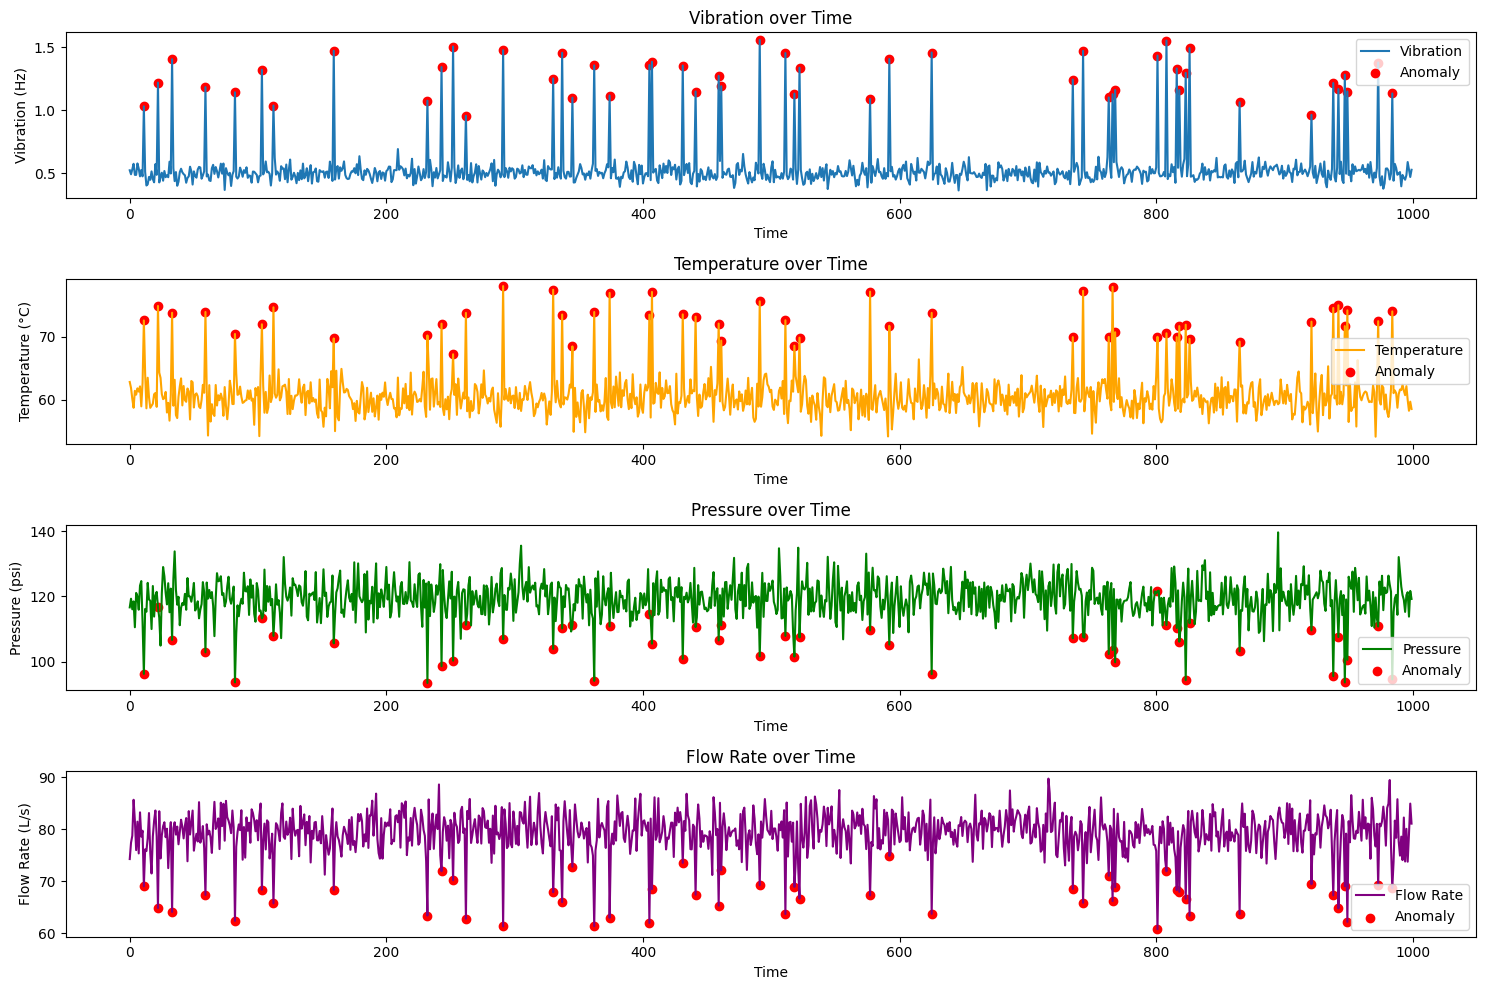

In [3]:
# Visualizing the data with anomalies highlighted
plt.figure(figsize=(15, 10))

# Vibration Plot
plt.subplot(4, 1, 1)
plt.plot(data['time'], data['vibration'], label='Vibration')
plt.scatter(data['time'][data['is_anomaly'] == 1], data['vibration'][data['is_anomaly'] == 1], color='red', label='Anomaly')
plt.title('Vibration over Time')
plt.xlabel('Time')
plt.ylabel('Vibration (Hz)')
plt.legend()

# Temperature Plot
plt.subplot(4, 1, 2)
plt.plot(data['time'], data['temperature'], label='Temperature', color='orange')
plt.scatter(data['time'][data['is_anomaly'] == 1], data['temperature'][data['is_anomaly'] == 1], color='red', label='Anomaly')
plt.title('Temperature over Time')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()

# Pressure Plot
plt.subplot(4, 1, 3)
plt.plot(data['time'], data['pressure'], label='Pressure', color='green')
plt.scatter(data['time'][data['is_anomaly'] == 1], data['pressure'][data['is_anomaly'] == 1], color='red', label='Anomaly')
plt.title('Pressure over Time')
plt.xlabel('Time')
plt.ylabel('Pressure (psi)')
plt.legend()

# Flow Rate Plot
plt.subplot(4, 1, 4)
plt.plot(data['time'], data['flow_rate'], label='Flow Rate', color='purple')
plt.scatter(data['time'][data['is_anomaly'] == 1], data['flow_rate'][data['is_anomaly'] == 1], color='red', label='Anomaly')
plt.title('Flow Rate over Time')
plt.xlabel('Time')
plt.ylabel('Flow Rate (L/s)')
plt.legend()

plt.tight_layout()
plt.show()


## **4. Data Preprocessing**

Before training the model, we will:
1. **Scale the features** to ensure they are on the same scale.
2. **Split the data** into training and test sets.
   - The training set will only contain normal data (no anomalies).
   - The test set will contain both normal and anomalous data for evaluation.


In [ ]:
# Separate features and labels
X = data[['vibration', 'temperature', 'pressure', 'flow_rate']]
y = data['is_anomaly']

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split: Only use normal data (is_anomaly = 0) for training
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Only keep normal data (is_anomaly = 0) in the training set
X_train_normal = X_train[y_train == 0]


## **5. Train Isolation Forest Model**

We will now train the **Isolation Forest** model using the normal training data. This model works by isolating data points through recursive partitioning, making it well-suited for outlier detection.


In [ ]:
# Train Isolation Forest model on normal data
iso_forest = IsolationForest(contamination=anomaly_fraction, random_state=42)
iso_forest.fit(X_train_normal)

IsolationForest(contamination=0.05, random_state=42)

## **6. Model Evaluation**

We will evaluate the model using the test set, which includes both normal and anomalous data. The model will predict whether each point is an anomaly or normal. We will also visualize the confusion matrix and print the classification report.


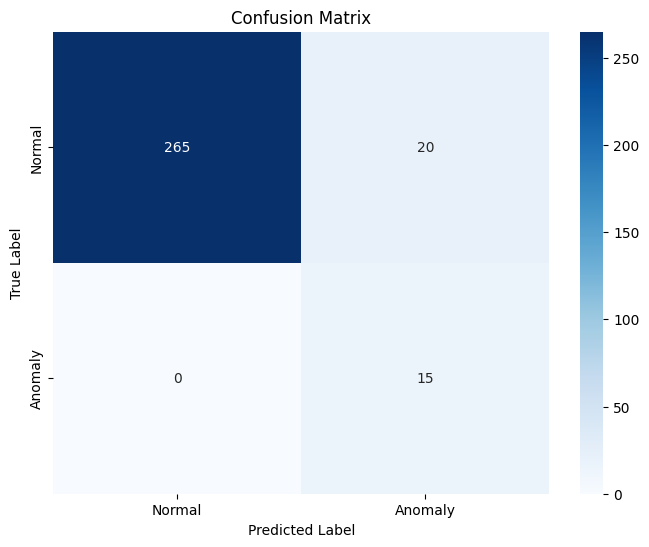

Classification Report:
               precision    recall  f1-score   support

      Normal       1.00      0.93      0.96       285
     Anomaly       0.43      1.00      0.60        15

    accuracy                           0.93       300
   macro avg       0.71      0.96      0.78       300
weighted avg       0.97      0.93      0.95       300



In [ ]:
# Predict anomalies on the test set
y_pred_test = iso_forest.predict(X_test)

# IsolationForest outputs -1 for anomalies and 1 for normal data, so we need to adjust it
y_pred_test_adjusted = np.where(y_pred_test == -1, 1, 0)  # 1 for anomaly, 0 for normal

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred_test_adjusted)
class_report = classification_report(y_test, y_pred_test_adjusted, target_names=['Normal', 'Anomaly'])

# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Display the classification report
print("Classification Report:\n", class_report)


## **Conclusion**

In this notebook, we successfully implemented an anomaly detection model for oil pump operations using the Isolation Forest algorithm. Below is a detailed breakdown of the results, followed by insights and future directions for improvement.

---

### **Confusion Matrix Breakdown**:
The confusion matrix provides a detailed look at how well our model classified normal and anomalous data points. Here's the breakdown:

- **True Positives (Anomalies detected correctly)**: 15
  - The model correctly identified 15 out of 15 actual anomalies in the test data.
  
- **False Positives (Normal points incorrectly flagged as anomalies)**: 20
  - The model incorrectly labeled 20 normal data points as anomalies, leading to a lower precision score for anomaly detection.
  
- **True Negatives (Normal points correctly identified)**: 265
  - The model correctly identified 265 out of 285 normal data points, showing strong performance in detecting normal operation.
  
- **False Negatives (Anomalies missed)**: 0
  - Importantly, the model did not miss any anomalies; all 15 anomalies were detected.

---

### **Classification Report Breakdown**:
The classification report provides further insight into the precision and recall for each class (Normal and Anomaly).

#### **Precision**:
- **Normal: 100%**
  - The model perfectly detected normal data, meaning it didn’t falsely classify any anomalies as normal.
  - Out of all points labeled as "normal," 100% were indeed normal.

- **Anomaly: 43%**
  - This value reflects that 43% of the points flagged as anomalies were true anomalies, while the remaining 57% were actually normal points that the model falsely labeled as anomalies.
  - The lower precision indicates the model had some difficulty distinguishing between normal points and anomalies, leading to false positives.

#### **Recall**:
- **Normal: 93%**
  - The model was able to correctly identify 93% of the normal points. However, it mistakenly flagged 7% of normal points as anomalies (false positives), slightly reducing recall for the normal class.
  
- **Anomaly: 100%**
  - The model detected all anomalies with perfect recall, meaning no anomalies were missed. This high recall is crucial in anomaly detection scenarios where missing an anomaly can have serious consequences.

#### **F1-Score**:
- **Normal: 96%**
  - The F1-Score balances precision and recall. With perfect precision (100%) and a strong recall (93%), the F1-score for normal data is very high, reflecting an excellent overall performance.
  
- **Anomaly: 60%**
  - The F1-score for anomaly detection is moderate at 60%. This is due to the trade-off between perfect recall (100%) and lower precision (43%).

#### **Accuracy**:
- **Overall Accuracy: 93%**
  - The model correctly classified 93% of all data points, demonstrating good overall performance in distinguishing between normal and anomalous pump operations.

---

### **Key Insights**:
1. **Perfect Recall for Anomalies**:
   - The model was very successful in detecting anomalies, achieving **100% recall**. This means the model didn’t miss any actual faults or anomalies, which is a crucial requirement in anomaly detection for industrial applications.
   
2. **False Positives for Anomalies**:
   - While recall for anomalies is perfect, the model struggled with **precision for anomalies**. It flagged 20 normal points as anomalies, which reduces the precision for anomalies to 43%. In real-world applications, a high number of false positives can lead to unnecessary maintenance or downtime, so this is an area for improvement.

3. **Strong Performance in Identifying Normal Operations**:
   - The model accurately classified **93% of normal points** as normal. This is important because it means the model can reliably detect when the system is functioning normally, minimizing disruptions due to false anomaly flags.

4. **Overall Accuracy**:
   - With an overall accuracy of **93%**, the model performed well, balancing the detection of anomalies with the identification of normal operations.

---

### **Future Directions**:
While the current model shows strong performance in detecting anomalies, especially with a perfect recall, there are areas for improvement that can help enhance the model’s utility in real-world scenarios:

1. **Improve Precision for Anomalies**:
   - Reducing the number of false positives (normal points flagged as anomalies) is crucial for a more precise model. Techniques like:
     - **Hyperparameter tuning** of the Isolation Forest (e.g., contamination level, number of estimators).
     - **Refining feature selection** by incorporating additional parameters related to oil pump performance, such as motor current or vibration frequency analysis.
     - **Advanced anomaly detection algorithms** like One-Class SVM, autoencoders, or deep learning models could potentially reduce false positives.

2. **Incorporate Temporal Data**:
   - Oil pump systems often have temporal dependencies (e.g., trends over time). Introducing **time-series-based models** (such as LSTM-based models or Temporal Isolation Forest) could help improve accuracy by capturing the sequential nature of the data.

3. **Real-World Data Application**:
   - Applying the model to real-world datasets, which include more noise and varied types of anomalies, would give a clearer picture of the model's real-world efficacy. The current synthetic data is useful for demonstration, but real-world operational data might require additional preprocessing and model adjustments.

4. **Threshold Adjustment**:
   - Adjusting the anomaly detection threshold could improve the balance between precision and recall. Currently, the contamination parameter is set at 5%, but this could be tuned based on the desired trade-off between false positives and false negatives.

5. **Hybrid Models**:
   - Combining Isolation Forest with other unsupervised or semi-supervised learning techniques could further enhance anomaly detection performance. For example, using **ensemble methods** that integrate predictions from multiple models might lead to better generalization.

6. **Predictive Maintenance**:
   - The current model focuses on anomaly detection. However, further development could involve using **predictive maintenance models** that forecast when an oil pump is likely to fail. This can be done by analyzing degradation trends over time and predicting when anomalies will occur.

---

### **Conclusion Recap**:
- **Model Strengths**:
  - 100% recall for anomalies ensures no anomalies are missed.
  - 93% overall accuracy reflects good performance in both anomaly and normal data classification.

- **Areas for Improvement**:
  - The precision for anomalies needs enhancement to reduce false positives.
  - Exploring advanced techniques and real-world data application will be essential for improving precision and ensuring practical utility.

This workflow can be a solid foundation for further exploration into **predictive maintenance** and **fault detection** systems in oil and gas industries, ultimately helping to minimize downtime and optimize operational efficiency.
